# BERT and HuggingFace

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EvalPrediction
)
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-04-24 18:55:49.798267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745542550.289768 1271485 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745542550.433347 1271485 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745542551.747253 1271485 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745542551.747276 1271485 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745542551.747279 1271485 computation_placer.cc:177] computation placer alr

In [ ]:
df = pd.read_csv("uniform_excerpts_2.csv")

# encode the era labels
label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["label"])
df.head()

,text,text_number,label,label_id
0,"seen that my intention was, to shew them that ...",15469,1700s,3
1,"the spectacle. Mrs. Charmond did not see them,...",482,1800s,4
2,King and the ladies of the Court rode out to t...,467,1600s,2
3,"assembly, he had published a letter, in which ...",1346,1800s,4
4,"some moan. '""Lo, all these trophies of affecti...",1137,1500s,1


In [3]:
df.shape

(5949, 4)

In [ ]:
# train/val/test split
# 80/10/10
train_df, val_test_df = train_test_split(df, test_size=0.2, stratify=df["label_id"], random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df["label_id"], random_state=42)

In [5]:
train_df.shape

(4759, 4)

In [6]:
val_df.shape

(595, 4)

In [7]:
test_df.shape

(595, 4)

In [ ]:
train_dataset = Dataset.from_pandas(train_df[["text", "label_id"]].rename(columns={"label_id": "labels"}))
val_dataset = Dataset.from_pandas(val_df[["text", "label_id"]].rename(columns={"label_id": "labels"}))
test_dataset = Dataset.from_pandas(test_df[["text", "label_id"]].rename(columns={"label_id": "labels"}))

In [9]:
def tokenize_dataset(model_name, train_df, val_df, test_df):
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

    def tokenize_function(examples):
        return tokenizer(
            examples["text"], truncation=True, padding="max_length", max_length=256
        )

    def prepare(dataset):
        dataset = Dataset.from_pandas(dataset[["text", "label_id"]].rename(columns={"label_id": "labels"}))
        dataset = dataset.map(tokenize_function, batched=True)
        dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
        return dataset

    return tokenizer, prepare(train_df), prepare(val_df), prepare(test_df)

In [10]:
def train_model(model_name, label_encoder, train_dataset, val_dataset, tokenizer):
    model = DistilBertForSequenceClassification.from_pretrained(
        model_name, num_labels=len(label_encoder.classes_)
    )

    training_args = TrainingArguments(
        output_dir="./era_model",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        logging_dir="./logs",
        report_to="none",
        learning_rate=1e-4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=6,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy"
    )

    def compute_metrics(p: EvalPrediction):
        preds = np.argmax(p.predictions, axis=1)
        return {"accuracy": accuracy_score(p.label_ids, preds)}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics
    )

    trainer.train()
    return trainer

In [11]:
model_name = 'distilbert-base-uncased'

In [12]:
tokenizer, train_dataset, val_dataset, test_dataset = tokenize_dataset(model_name, train_df, val_df, test_df)

Map:   0%|          | 0/4759 [00:00<?, ? examples/s]

Map:   0%|          | 0/595 [00:00<?, ? examples/s]

Map:   0%|          | 0/595 [00:00<?, ? examples/s]

In [13]:
trainer = train_model(
    model_name=model_name,
    label_encoder=label_encoder,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    tokenizer=tokenizer
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/projects/edki2977/software/anaconda/envs/mynlp/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/scratch/alpine/edki2977/.tmp/ipykernel_1271485/1891494769.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.959300,0.786374,0.672269
2,0.516200,0.738479,0.722689
3,0.267700,1.000021,0.710924
4,0.140300,1.127532,0.742857
5,0.059100,1.230121,0.757983
6,0.012700,1.394429,0.752941


In [14]:
log_history = trainer.state.log_history

train_loss = []
val_loss = []
epochs = []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log and "epoch" in log:
        val_loss.append(log["eval_loss"])
    if "epoch" in log:
        epochs.append(log["epoch"])

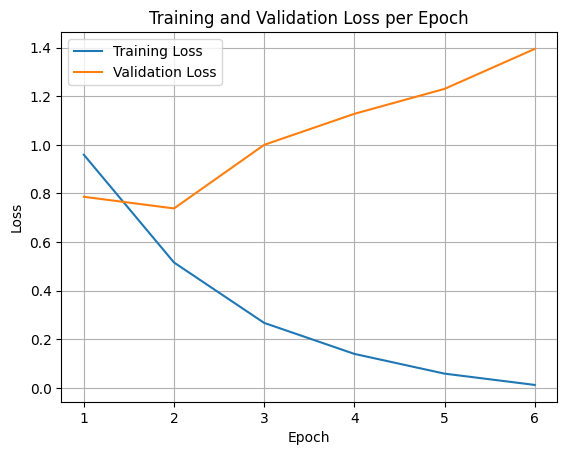

In [ ]:
unique_epochs = sorted(set([log["epoch"] for log in log_history if "epoch" in log]))

train_loss = [log["loss"] for log in log_history if "loss" in log and "epoch" in log]
val_loss = [log["eval_loss"] for log in log_history if "eval_loss" in log and "epoch" in log]

plt.plot(unique_epochs[:len(train_loss)], train_loss, label="Training Loss")
plt.plot(unique_epochs[:len(val_loss)], val_loss, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# eval on test set
results = trainer.evaluate(test_dataset)
print("Test Results:", results)

Test Results: {'eval_loss': 1.2345798015594482, 'eval_accuracy': 0.761344537815126, 'eval_runtime': 24.9176, 'eval_samples_per_second': 23.879, 'eval_steps_per_second': 1.525, 'epoch': 6.0}


In [ ]:
# f1, precision, recall
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids
print(classification_report(true_labels, pred_labels, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       1400s       0.90      0.93      0.91        95
       1500s       0.91      0.93      0.92       100
       1600s       0.71      0.57      0.63       100
       1700s       0.52      0.67      0.59       100
       1800s       0.69      0.62      0.65       100
       1900s       0.90      0.86      0.88       100

    accuracy                           0.76       595
   macro avg       0.77      0.76      0.76       595
weighted avg       0.77      0.76      0.76       595



In [18]:
log_history = trainer.state.log_history
df = pd.DataFrame(log_history)
df.head()

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.9593,10.514441,0.000083,1.0,298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,298,0.786374,0.672269,23.7007,25.105,1.603,NaN,NaN,NaN,NaN,NaN
2,0.5162,14.272511,0.000067,2.0,596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,2.0,596,0.738479,0.722689,23.0506,25.813,1.649,NaN,NaN,NaN,NaN,NaN
4,0.2677,9.717100,0.000050,3.0,894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_loss = df[df['loss'].notna()][['epoch', 'loss']]
test_loss = df[df['eval_loss'].notna()][['epoch', 'eval_loss']]
test_acc = df[df['eval_accuracy'].notna()][['epoch', 'eval_accuracy']]

In [20]:
print(df[df['epoch'] == 4][['epoch', 'eval_loss']])

   epoch  eval_loss
6    4.0        NaN
7    4.0   1.127532


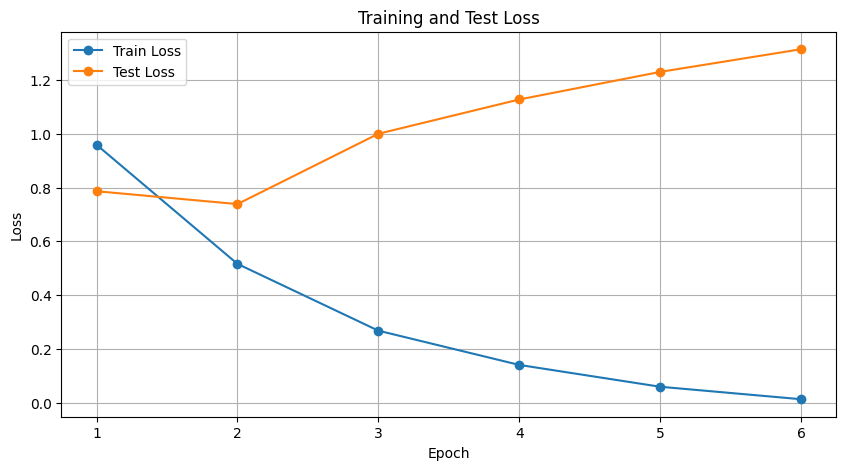

In [ ]:
test_loss_grouped = test_loss.groupby('epoch', as_index=False).mean()
train_loss_grouped = train_loss.groupby('epoch', as_index=False).mean()

# plot train and test losses
plt.figure(figsize=(10, 5))
plt.plot(test_loss_grouped['epoch'], train_loss_grouped['loss'], label='Train Loss', marker='o')
plt.plot(test_loss_grouped['epoch'], test_loss_grouped['eval_loss'], label='Test Loss', marker='o')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")

plt.legend()
plt.grid(True)
plt.show()

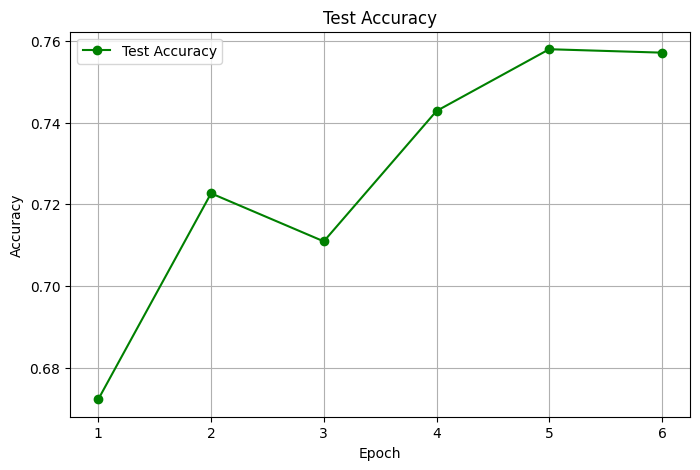

In [ ]:
test_acc_grouped = test_acc.groupby('epoch', as_index=False).mean()

# test accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(test_acc_grouped['epoch'], test_acc_grouped['eval_accuracy'], label='Test Accuracy', marker='o', color='green')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")

plt.legend()
plt.grid(True)
plt.show()

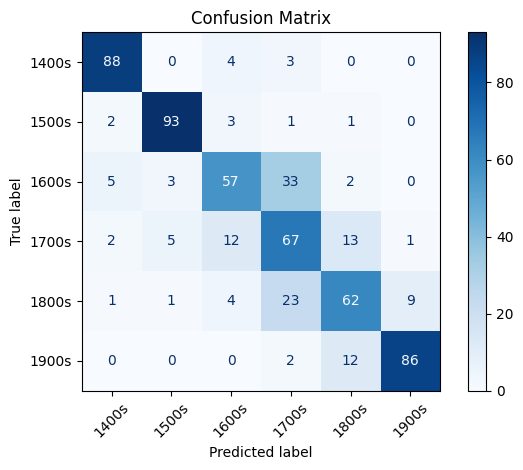

In [ ]:
# confusion matrix for test classification vs actual
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()